In [112]:
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
from utils import OCRTokenizer, OCRDataset, collate_batch, save_experiment_info

import numpy as np
import matplotlib.pyplot as plt

import torch
import torchinfo

TrOCR Captcha finetuning \
https://colab.research.google.com/drive/14MfFkhgPS63RJcP7rpBOK6OII_y34jx_?usp=sharing#scrollTo=3VazhIpdx7mW

In [115]:
tokenizer = OCRTokenizer('./synthetic_dataset/train/labels.txt')
tokenizer.counter.most_common(5)

[(' ', 10061), ('8', 3028), ('S', 3012), ('b', 3006), ('V', 2992)]

In [143]:
train_dataset = OCRDataset('./synthetic_dataset/train/', tokenizer, do_train_transform=True, image_size=(384, 384))  # need quadratic images for vit, 64 h for others
val_dataset = OCRDataset('./synthetic_dataset/val/', tokenizer, do_train_transform=False, image_size=(384, 384))
test_dataset = OCRDataset('./synthetic_dataset/test_clean/', tokenizer, do_train_transform=False, image_size=(384, 384))
test_captchas_dataset = OCRDataset('./synthetic_dataset/test_captchas/', tokenizer, do_train_transform=False, image_size=(384, 384))
len(train_dataset), len(val_dataset), len(test_dataset), len(test_captchas_dataset)

(20000, 1500, 5000, 5000)

In [117]:
processor = TrOCRProcessor.from_pretrained('microsoft/trocr-base-printed')
model = VisionEncoderDecoderModel.from_pretrained('microsoft/trocr-base-printed')
model

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-printed and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


VisionEncoderDecoderModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0): ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=False)
              (key): Linear(in_features=768, out_features=768, bias=False)
              (value): Linear(in_features=768, out_features=768, bias=False)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=76

In [120]:
torchinfo.summary(model)

Layer (type:depth-idx)                                       Param #
VisionEncoderDecoderModel                                    --
├─ViTModel: 1-1                                              --
│    └─ViTEmbeddings: 2-1                                    443,904
│    │    └─ViTPatchEmbeddings: 3-1                          590,592
│    │    └─Dropout: 3-2                                     --
│    └─ViTEncoder: 2-2                                       --
│    │    └─ModuleList: 3-3                                  85,026,816
│    └─LayerNorm: 2-3                                        1,536
│    └─ViTPooler: 2-4                                        --
│    │    └─Linear: 3-4                                      590,592
│    │    └─Tanh: 3-5                                        --
├─TrOCRForCausalLM: 1-2                                      --
│    └─TrOCRDecoderWrapper: 2-5                              --
│    │    └─TrOCRDecoder: 3-6                                247,268,352


In [121]:
processor((test_dataset[1]['image']*255).to(torch.uint8)).pixel_values[0].shape

(3, 384, 384)

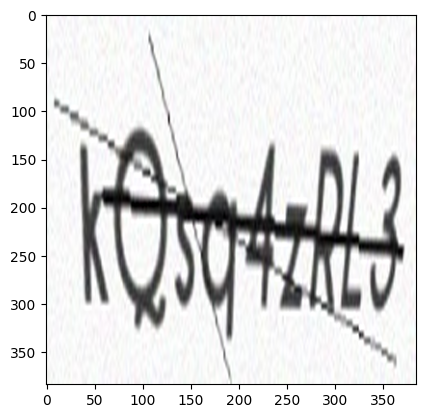

In [167]:
test_image = test_captchas_dataset[np.random.randint(0, len(test_captchas_dataset))]['image']
plt.imshow(test_image.permute(1, 2, 0))

In [132]:
test_dataset[0]['image'].shape

torch.Size([3, 384, 384])

In [133]:
processor.tokenizer

PreTrainedTokenizerFast(name_or_path='microsoft/trocr-base-printed', vocab_size=50265, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'eos_token': AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'unk_token': AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'sep_token': AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'pad_token': AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'cls_token': AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'mask_token': AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=True)})

In [168]:
generated_ids = model.generate(test_image.unsqueeze(0))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


In [169]:
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)
generated_text

['KOSQ42RL3']